Explained variance ratio: [0.21961673 0.12895882 0.07157651]


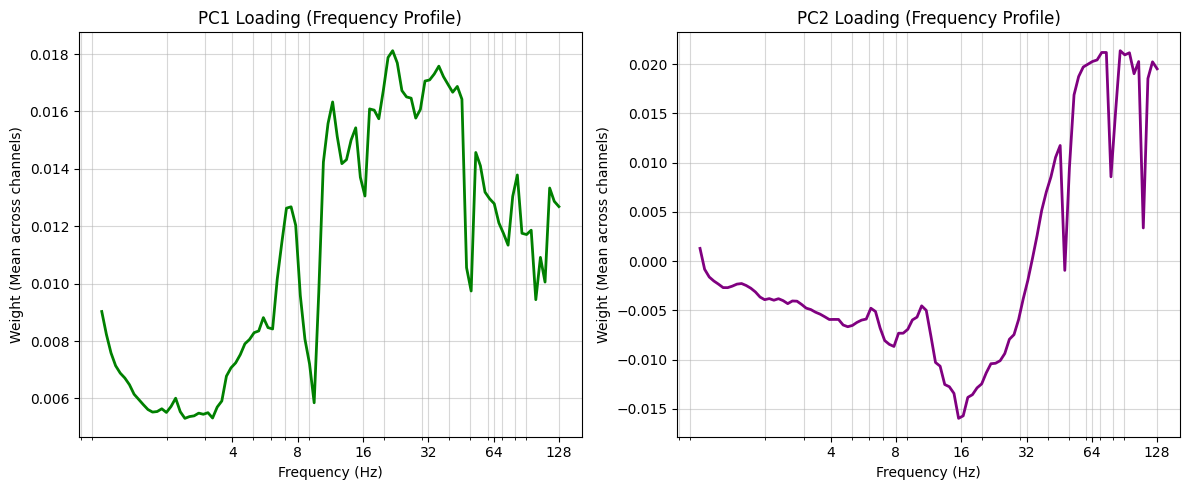

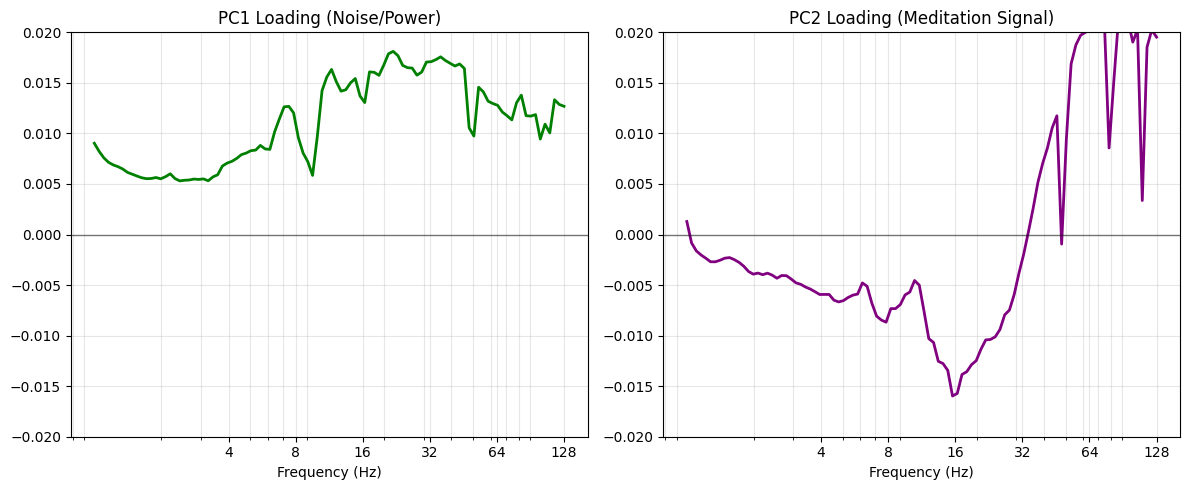

--- Hybrid Filter (Function: get_strong_meditation_trials) ---
  Expert (Threshold >= 4.0) : 49 trials
  Amateur (Top-20.0 w/ fill) : 37 trials
  Total : 86 trials


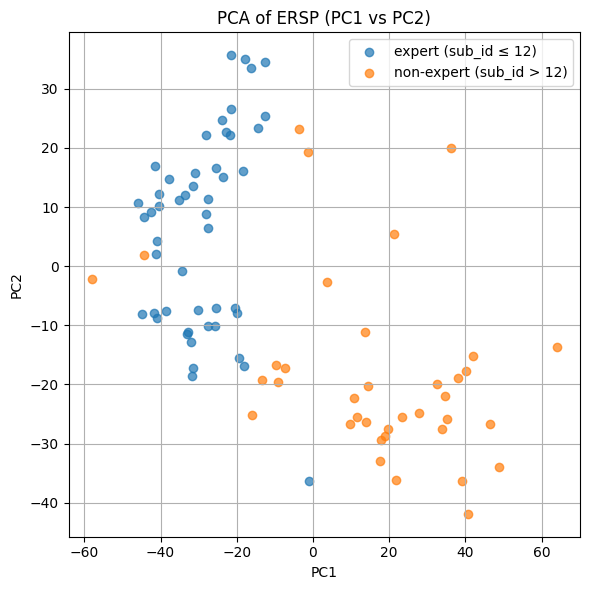

[cache] load cluster results from cache/cluster_expert_results.npz, T_obs_all.shape=(64, 100, 197)


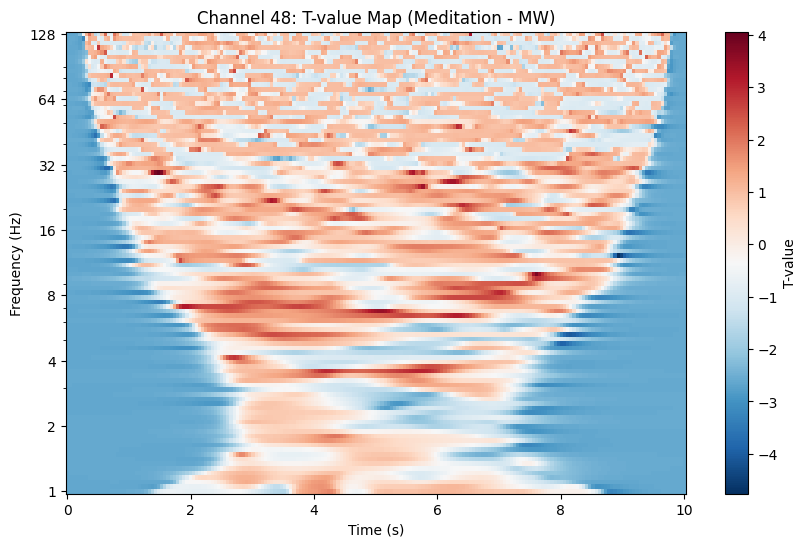

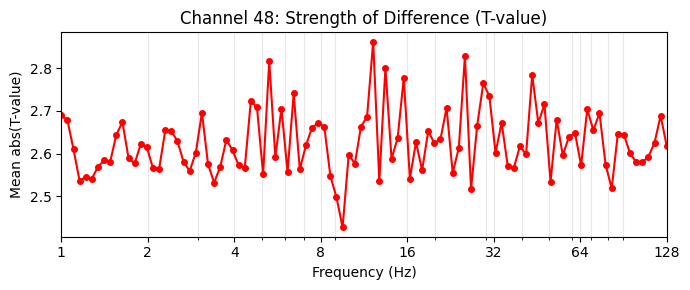

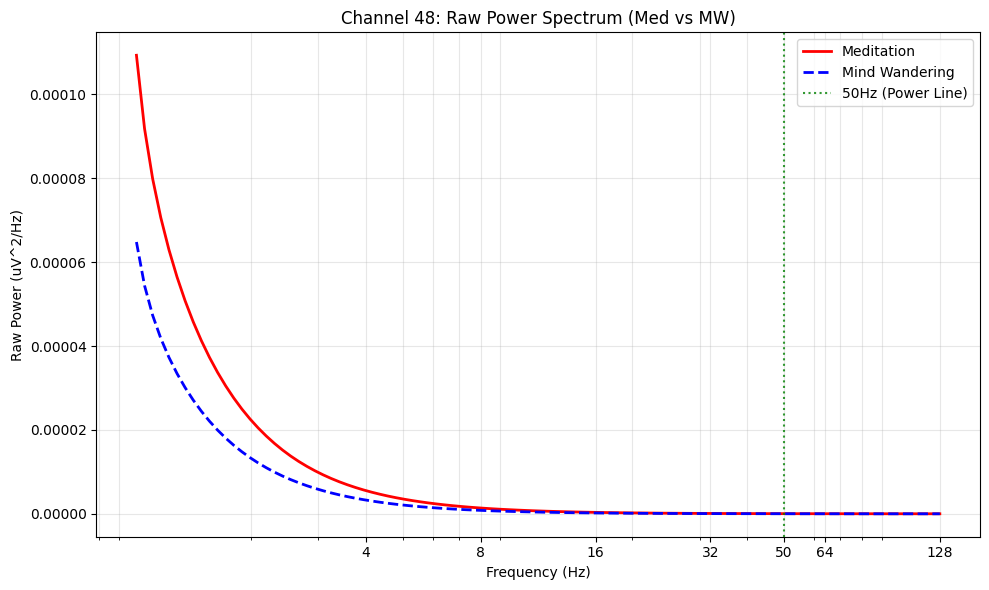

ch 48: 有意freq数 = 100
最小freq = 1.00 Hz
最大freq = 128.00 Hz

  idx=  0, freq=  1.00 Hz, count= 52
  idx=  1, freq=  1.05 Hz, count= 61
  idx=  2, freq=  1.10 Hz, count= 71
  idx=  3, freq=  1.16 Hz, count= 77
  idx=  4, freq=  1.22 Hz, count= 72
  idx=  5, freq=  1.28 Hz, count= 79
  idx=  6, freq=  1.34 Hz, count= 83
  idx=  7, freq=  1.41 Hz, count= 86
  idx=  8, freq=  1.48 Hz, count= 90
  idx=  9, freq=  1.55 Hz, count=106
  idx= 10, freq=  1.63 Hz, count=107
  idx= 11, freq=  1.71 Hz, count= 94
  idx= 12, freq=  1.80 Hz, count= 97
  idx= 13, freq=  1.89 Hz, count=102
  idx= 14, freq=  1.99 Hz, count=106
  idx= 15, freq=  2.09 Hz, count= 91
  idx= 16, freq=  2.19 Hz, count= 92
  idx= 17, freq=  2.30 Hz, count=102
  idx= 18, freq=  2.42 Hz, count= 99
  idx= 19, freq=  2.54 Hz, count= 96
  idx= 20, freq=  2.67 Hz, count=104
  idx= 21, freq=  2.80 Hz, count= 93
  idx= 22, freq=  2.94 Hz, count=101
  idx= 23, freq=  3.09 Hz, count= 98
  idx= 24, freq=  3.24 Hz, count= 91
  idx= 25, freq= 

In [60]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import mne
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, LeaveOneGroupOut
from mne.time_frequency import tfr_array_morlet
from sklearn.decomposition import PCA
from mne.stats import permutation_cluster_1samp_test
import plotly.express as px
import plotly.io as pio
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler


# ---------------------------------------------------------
# 関数
# ---------------------------------------------------------


# ----- sデータの読み込み & Raw からの EEG ファイルの抽出 -----
def getRawEEG(BDF_PATH, CH_TSV):
    # BDF読み込み
    raw = mne.io.read_raw_bdf(BDF_PATH, preload=True, verbose=False)

    # BDF読み込み後の生データの「チャンネル名のリネーム」&「タイプ設定」
    raw = renameChannelAndSetTypeForRawData(CH_TSV, raw)

    # EEGのみピックアップ & 電極位置の設定
    raw_eeg = raw.copy().pick(["eeg"])
    raw_eeg.set_montage("biosemi64", on_missing="ignore")

    return raw_eeg


# ----- 生データのリネームとタイプ設定 -----
def renameChannelAndSetTypeForRawData(CH_TSV, raw):
    if os.path.exists(CH_TSV):
        chan = pd.read_csv(CH_TSV, sep="\t")

        rename_map = {old: new for old, new in zip(raw.ch_names, chan["name"])}
        raw.rename_channels(rename_map)

        map_bids_to_mne = {
            "EEG": "eeg",
            "MISC": "misc",
            "GSR": "bio",
            "RESP": "resp",
            "PPG": "bio",
            "TEMP": "misc",
        }

        type_map = {
            name: map_bids_to_mne.get(type_, "eeg")
            for name, type_ in zip(chan["name"], chan["type"])
        }

        return raw.set_channel_types(type_map)


# ----- 有効な Probe の抽出 -----
def getValidProbes(EV_TSV):
    ev = pd.read_csv(EV_TSV, sep="\t")

    # duration は一応埋めておく（今回はほぼ使わないけど安全のため）
    ev["duration"] = ev["duration"].fillna(0.0)

    # Stimulus (value=128) を特定
    is_stimulus = (ev["trial_type"] == "stimulus") & (ev["value"] == 128)

    # グループIDを付与（各行がどのプローブに属するか）
    ev["probe_group_idx"] = is_stimulus.cumsum()
    stim_idx = ev.index[is_stimulus]

    # ラベリング用の列を追加
    ev["Q1"] = np.nan
    ev["Q2"] = np.nan
    ev["probe_label"] = None  # "meditation" / "mind_wandering" / "exclude"
    ev["trial_start"] = ev["onset"] - 10.0  # onset - 10 秒
    ev["valid_probe"] = False  # 初期化

    for i in range(len(stim_idx)):
        current_idx = stim_idx[i]

        # 元のロジックを踏襲して「このプローブの範囲」を決める
        if (i + 1) < len(stim_idx):
            next_idx = stim_idx[i + 1]
            if next_idx - current_idx >= 4:
                probe_slice = slice(current_idx, next_idx - 1)
            else:
                continue
        else:
            # 最後の stimulus
            if len(ev) - current_idx >= 3:
                probe_slice = slice(current_idx, current_idx + 3)
            else:
                continue

        # このプローブに属する行たち
        group = ev.loc[probe_slice]

        # response 行を取得
        responses = group[group["trial_type"] == "response"]

        # 先頭2つを Q1/Q2 として扱う
        q1 = float(responses["value"].iloc[0])
        q2 = float(responses["value"].iloc[1])

        # ラベル判定
        if q1 > q2:
            label = "meditation"
        elif q2 > q1:
            label = "mind_wandering"
        else:
            label = "exclude"

        # このプローブに属する全行へ書き込み
        ev.loc[group.index, "Q1"] = q1
        ev.loc[group.index, "Q2"] = q2
        ev.loc[group.index, "probe_label"] = label

        # 「除外」以外を有効プローブとして採用
        if label != "exclude":
            ev.loc[group.index, "valid_probe"] = True

    valid_probes = ev[ev["valid_probe"]].copy()
    return valid_probes


# ----- Probe 単位で行を結合 & 列の設定 -----
def extractTrials(valid_probes):
    probe_df = (
        valid_probes
        .groupby("probe_group_idx")
        .agg(
            t_start=("trial_start", "min"),   # 開始の最小値
            t_end=("onset", "min"),           # 終了の最大値
            event_count=("trial_type", "size"),
            probe_label=("probe_label", "first"),  # "meditation" / "mind_wandering"
            Q1=("Q1", "first"),
            Q2=("Q2", "first"),
        )
        .reset_index()
    )

    return probe_df


def getERSPs(probe_df, raw_eeg):
    # 周波数軸とサイクル数（論文仕様）
    freqs = np.logspace(np.log10(1.0), np.log10(128.0), 100)
    n_cycles = np.linspace(3.0, 60.0, len(freqs))

    ersp_list = []

    for _, row in probe_df.iterrows():
        t_min = row["t_start"]
        t_max = row["t_end"]

        # 1トライアル（直前10秒）を切り出し
        crop = raw_eeg.copy().crop(tmin=t_min, tmax=t_max)
        data = crop.get_data()[np.newaxis, :, :]  # (1, n_channels, n_times)

        # 10秒ぶんのサンプル数をざっくり200点くらいに間引くための decim を計算
        sample_num = data.shape[-1]
        decim = max(1, int(round(sample_num / 200)))

        # Morlet wavelet による ERSP (power)
        power = tfr_array_morlet(
            data,
            sfreq=crop.info["sfreq"],
            freqs=freqs,
            n_cycles=n_cycles,
            output="power",
            decim=decim,  # ← ここを追加
        )[0]  # (n_channels, n_freqs, n_times)

        ersp_list.append(power)

    # 各プローブ行に「このトライアルの ERSP（ch×freq×time）」を持たせる
    probe_df["ersp"] = ersp_list
    return probe_df


# ----- 任意のセッションから特徴量を取得 -----
def processingSession(sub_id, session_id, BDF_PATH, CH_TSV, EV_TSV):
    print(session_id)

    raw_eeg = getRawEEG(BDF_PATH, CH_TSV)
    valid_probes = getValidProbes(EV_TSV)      # 有効なプローブの抽出
    probe_df = extractTrials(valid_probes)     # サンプルの切り出し
    probe_df = getERSPs(probe_df, raw_eeg)     # サンプルから特徴量を取得

    probe_df["sub_id"] = sub_id
    probe_df["session_id"] = session_id

    return probe_df


# ---------------------------------------------------------
# ロジスティック回帰
# ---------------------------------------------------------
# def excuteLogisticRegression(probe_df):
#     # 1. 特徴量とラベル・グループを用意
#     EPS = 1e-20  # log10用の安全マージン
#     X_raw = probe_df[["alpha_power", "theta_power"]].values
#     # X_raw = probe_df[["alpha_power", "theta_power"]].values
#     X = np.log10(X_raw + EPS)
#
#     # 正解ラベル (ID 12以下なら1, それ以外は0)
#     y = (probe_df["sub_id"].astype(int) <= 12).astype(int).values
#
#     # グループ情報（被験者ID）
#     groups = probe_df["sub_id"].astype(int).values
#
#     print(f"総サンプル数 (Probe数): {len(y)}")
#     print(f"ユニークな被験者数: {len(np.unique(groups))}")
#
#     # 2. Leave-One-Group-Out （被験者ごとに1人ずつテスト）
#     logo = LeaveOneGroupOut()
#     acc_list = []
#
#     print("\n=== Leave-One-Subject-Out CV (被験者ごとに1人テスト) ===")
#
#     for i, (train_idx, test_idx) in enumerate(logo.split(X, y, groups), start=1):
#         test_sub_ids = np.unique(groups[test_idx])    # 通常は1つだけのはず
#         test_sub_id = int(test_sub_ids[0])
#
#         X_train, X_test = X[train_idx], X[test_idx]
#         y_train, y_test = y[train_idx], y[test_idx]
#
#         # 3. スケーリング（学習データで fit → テストに transform）
#         scaler = StandardScaler()
#         X_train_scaled = scaler.fit_transform(X_train)
#         X_test_scaled = scaler.transform(X_test)
#
#         # 4. 学習
#         clf = LogisticRegression(random_state=42, max_iter=1000)
#         clf.fit(X_train_scaled, y_train)
#
#         # 5. 評価
#         y_pred = clf.predict(X_test_scaled)
#         acc = accuracy_score(y_test, y_pred)
#         acc_list.append(acc)
#
#         print(f"Fold {i:02d} | Test Subject {test_sub_id:02d} | n={len(y_test):3d} | acc={acc:.4f}")
#
#     # 6. 全体の平均
#     print("\n--- 全被験者の平均 ---")
#     print(f"平均 Accuracy: {np.mean(acc_list):.4f}")
#     print(f"Accuracy のばらつき (std): {np.std(acc_list):.4f}")


# ---------------------------------------------------------
# PCA
# ---------------------------------------------------------

# def runPCA(all_probe_df, n_components=2):
#     """
#     all_probe_df["ersp"] に入っている ERSP (ch × freq × time) を flatten して PCA にかけ、
#     pc1, pc2, ... を列として追加する。
#     """
#     # 1. ersp（3D配列）を 1 トライアル = 1 ベクトル に flatten
#     flat_ersp_list = []

#     for ersp in all_probe_df["ersp"]:
#         # ersp: shape = (n_channels, n_freqs, n_times)
#         flat_vec = ersp.ravel()  # (n_channels * n_freqs * n_times,)
#         flat_ersp_list.append(flat_vec)

#     # リストを 2次元配列 (n_trials, n_features) にまとめる
#     X = np.stack(flat_ersp_list, axis=0)

#     # 2. PCA
#     pca = PCA(n_components=n_components)
#     X_pca = pca.fit_transform(X)  # shape = (n_trials, n_components)

#     # 中身は「各トライアルが、主成分空間上（PC1, PC2）でどの位置にいるか」の一覧。
#     print(X_pca)

#     # 3. 結果を DataFrame にそのままくっつける
#     pc1 = X_pca[:, 0]  # 1列目 → PC1
#     pc2 = X_pca[:, 1]  # 2列目 → PC2

#     all_probe_df["pc1"] = pc1
#     all_probe_df["pc2"] = pc2

#     return all_probe_df, pca


def runPCA_improved(all_probe_df, n_components=3):
    """
    改良版PCA:
    1. 対数変換 (dB) で1/fゆらぎを補正
    2. 時間方向の平均化で特徴量を安定化
    3. RobustScalerで外れ値の影響を除去
    """
     
    # 1. データをリストから 4次元配列に変換
    # Shape: (n_trials, n_channels, n_freqs, n_times)
    # all_probe_df["ersp"] は各行に (ch, freq, time) の配列が入っているリストと想定
    ersp_list = [arr for arr in all_probe_df["ersp"]]
    X_raw = np.stack(ersp_list, axis=0) 

    # ---------------------------------------------------------
    # 前処理 A: 対数変換 (dB変換)
    # ---------------------------------------------------------
    # これがないと、PCAは値の大きい「低周波」しか見ません。
    # logをとることで、高周波(Gammaなど)の変化もPCAが捉えられるようになります。
    # ※ log(0)を防ぐため微小値 1e-15 を加算
    X_log = 10 * np.log10(np.abs(X_raw) + 1e-15)

    # ---------------------------------------------------------
    # 前処理 B: 時間方向の平均化 (次元削減)
    # ---------------------------------------------------------
    # (n_trials, n_channels, n_freqs, n_times) -> (n_trials, n_channels, n_freqs)
    # 「10秒間でどの周波数が強かったか」という平均的な特徴量にします。
    # 時々刻々の変化よりも「状態」としての違いを見やすくします。
    X_mean_time = np.mean(X_log, axis=3)

    # 平坦化: (n_trials, n_features) にする
    # n_features = n_channels * n_freqs
    n_trials = X_mean_time.shape[0]
    X_flat = X_mean_time.reshape(n_trials, -1)

    # ---------------------------------------------------------
    # 前処理 C: スケーリング (RobustScaler)
    # ---------------------------------------------------------
    # 普通のStandardScalerだと、異常な外れ値に平均が引っ張られます。
    # RobustScalerは中央値を使うため、アーティファクト(外れ値)の影響を受けにくいです。
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X_flat)

    # ---------------------------------------------------------
    # 2. PCA 実行
    # ---------------------------------------------------------
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)

    # 寄与率の表示（PC1, PC2でデータの何%を説明できているか）
    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

    # 3. 結果を DataFrame に格納 (元のDFをコピーして使用)
    df_out = all_probe_df.copy()
    df_out["pc1"] = X_pca[:, 0]
    df_out["pc2"] = X_pca[:, 1]

    if n_components >= 3:
        df_out["pc3"] = X_pca[:, 2]

    return df_out, pca


# 主成分の基本的な解釈手順：https://chatgpt.com/s/t_69244caf11588191b242ee273097cc88
def showPCA2D(all_probe_df):
    pc1 = all_probe_df["pc1"].values
    pc2 = all_probe_df["pc2"].values

    # mask for expart/amature
    sub_id = all_probe_df["sub_id"].astype(int).values
    expert_mask = sub_id <= 12

    # mask for meditation/mind_wandering
    # label = all_probe_df["probe_label"].values
    # med_mask = label == "meditation"
    # mw_mask = label == "mind_wandering"

    # 図を用意
    plt.figure(figsize=(6, 6))

    # エキスパート
    plt.scatter(
        pc1[expert_mask],
        pc2[expert_mask],
        label="expert (sub_id ≤ 12)",
        alpha=0.7,
    )

    # ノンエキスパート
    plt.scatter(
        pc1[~expert_mask],
        pc2[~expert_mask],
        label="non-expert (sub_id > 12)",
        alpha=0.7,
    )

    # 軸ラベル・タイトルなど
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("PCA of ERSP (PC1 vs PC2)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


def showPCA3D(all_probe_df):
    # 1. 表示用のラベル列を作る
    df = all_probe_df.copy()
    df["Expertise"] = df["sub_id"].astype(int).apply(lambda x: "Expert" if x <= 12 else "Non-Expert")
     
    # 2. Plotlyで描画
    fig = px.scatter_3d(
        df, 
        x='pc1', 
        y='pc2', 
        z='pc3',
        color='Expertise',                  # 色分けの基準
        hover_data=['sub_id', 'session_id'], # マウスを乗せた時に表示する情報
        labels={
            'pc1': 'PC1: Noise/Power',
            'pc2': 'PC2: Gamma (Focus)',
            'pc3': 'PC3: Theta/Alpha (Relax)'
        },
        title='Interactive 3D PCA: Expert vs Non-Expert',
        opacity=0.7,
        width=900,
        height=700
    )

    fig.update_traces(marker=dict(size=5)) # マーカーサイズを少し小さくして見やすく
    fig.show()
     

def plot_pca_loadings_base(pca, freqs):
    """
    PCAの第1成分(PC1)と第2成分(PC2)が、
    どの周波数を重視しているか（ローディング）を可視化する関数。
    """
    # 1. 配列形状の確認と設定
    n_components, n_features = pca.components_.shape
    n_freqs = len(freqs)
     
    # 特徴量数(ch * freq) から チャンネル数を逆算
    if n_features % n_freqs != 0:
        print(f"Error: 特徴量数({n_features})が周波数数({n_freqs})で割り切れません。")
        return
        
    n_channels = n_features // n_freqs

    # 2. 成分を取り出し、(チャンネル, 周波数) の形に戻す
    comp1 = pca.components_[0].reshape(n_channels, n_freqs)
    comp2 = pca.components_[1].reshape(n_channels, n_freqs)

    # 3. 全チャンネル平均をとり、「周波数ごとの重み」にする
    comp1_freq = np.mean(comp1, axis=0)
    comp2_freq = np.mean(comp2, axis=0)

    # 4. 描画
    plt.figure(figsize=(12, 5))
     
    tick_vals = [4, 8, 16, 32, 64, 128]
    tick_labels = [str(v) for v in tick_vals]

    # --- 左のグラフ：PC1 ---
    plt.subplot(1, 2, 1)
    plt.plot(freqs, comp1_freq, color='green', linewidth=2)
    plt.xscale('log')
    plt.title("PC1 Loading (Frequency Profile)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Weight (Mean across channels)")
    plt.grid(True, which='both', alpha=0.5)
    plt.xticks(tick_vals, tick_labels)

    # --- 右のグラフ：PC2 ---
    plt.subplot(1, 2, 2)
    plt.plot(freqs, comp2_freq, color='purple', linewidth=2)
    plt.xscale('log')
    plt.title("PC2 Loading (Frequency Profile)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Weight (Mean across channels)")
    plt.grid(True, which='both', alpha=0.5)
    plt.xticks(tick_vals, tick_labels)

    plt.tight_layout()
    plt.show()


def plot_pca_loadings(pca, freqs, ylim=None):
    """
    見やすさを改善したPCA成分（Loading）の可視化関数
    - 0のライン（基準線）を追加
    - グリッドを見やすく調整
    """
    n_components, n_features = pca.components_.shape
    n_freqs = len(freqs)
    n_channels = n_features // n_freqs

    comp1 = pca.components_[0].reshape(n_channels, n_freqs)
    comp2 = pca.components_[1].reshape(n_channels, n_freqs)

    comp1_freq = np.mean(comp1, axis=0)
    comp2_freq = np.mean(comp2, axis=0)

    plt.figure(figsize=(12, 5))
     
    tick_vals = [4, 8, 16, 32, 64, 128]
    tick_labels = [str(v) for v in tick_vals]

    # --- 左：PC1 ---
    plt.subplot(1, 2, 1)
    plt.plot(freqs, comp1_freq, color='green', linewidth=2)
    # ★基準線（0）を追加
    plt.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
     
    plt.xscale('log')
    plt.title("PC1 Loading (Noise/Power)")
    plt.xlabel("Frequency (Hz)")
    plt.grid(True, which='both', alpha=0.3)
    plt.xticks(tick_vals, tick_labels)
    if ylim: plt.ylim(ylim)

    # --- 右：PC2 ---
    plt.subplot(1, 2, 2)
    plt.plot(freqs, comp2_freq, color='purple', linewidth=2)
    # ★基準線（0）を追加
    plt.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
     
    plt.xscale('log')
    plt.title("PC2 Loading (Meditation Signal)")
    plt.xlabel("Frequency (Hz)")
    plt.grid(True, which='both', alpha=0.3)
    plt.xticks(tick_vals, tick_labels)
    if ylim: plt.ylim(ylim)

    plt.tight_layout()
    plt.show()


# ---------------------------------------------------------
# 論文の再現ルート
# ---------------------------------------------------------
# 被験者内で「瞑想平均ERSP − MW平均ERSP」を作る関数
def compute_subject_ersp_difference(all_probe_df):
    # ---- 被験者単位で 瞑想トライアル/MWトライアルに分けて収集する部分 ----
    # sub_id を int にそろえた列を作る
    df = all_probe_df.copy()
    df["sub_id_int"] = df["sub_id"].astype(int)

    # 「被験者単位のグループ」でトライアルを扱えるようにする
    groups = df.groupby("sub_id_int")

    diff_list = []        # 各被験者の差分ERSP (ch, freq, time)
    used_subjects = []    # 実際に使った被験者ID

    # groupby した結果の「キーの一覧」（= 被験者IDの一覧）
    subject_ids = sorted(groups.groups.keys())

    for subject_id in subject_ids:
        # 処理したい被験者の行だけ取り出す
        sub_df = groups.get_group(subject_id)

        # 取り出した行を、瞑想トライアル / MWトライアル に分けて扱う
        med_df = sub_df[sub_df["probe_label"] == "meditation"]
        mw_df = sub_df[sub_df["probe_label"] == "mind_wandering"]

        # ersp 列だけ取り出す（各要素は : ch, freq, time)
        # med_df["ersp"] は Pandas の Series
        # その Series を「ただの Python のリスト」に変換
        # 後の NumPy で行列に変換する
        med_trials = list(med_df["ersp"])
        mw_trials = list(mw_df["ersp"])

        n_med = len(med_trials)
        n_mw = len(mw_trials)

        # 差分を作れない場合はスキップ
        if n_med == 0 or n_mw == 0:
            print(
                f"[compute_subject_ersp_difference] Skip subject {subject_id}: "
                f"meditation={n_med}, mind_wandering={n_mw}"
            )
            continue

        # ---- ここから ERSP の計算部分 ----
        # --- 瞑想トライアルの平均ERSPを計算 ---
        # まず「全部ゼロ」の箱を用意する（形と型は1トライアルから借りる）
        med_shape = med_trials[0].shape   # (ch, freq, time)
        med_dtype = med_trials[0].dtype
        med_mean = np.zeros(med_shape, dtype=med_dtype)

        # 全トライアルを足し込む
        for trial in med_trials:
            med_mean = med_mean + trial

        # 足し終わったらトライアル数で割る → 被験者内の瞑想平均ERSP
        med_mean = med_mean / float(n_med)

        # --- MWトライアルの平均ERSPを計算 ---
        mw_shape = mw_trials[0].shape
        mw_dtype = mw_trials[0].dtype
        mw_mean = np.zeros(mw_shape, dtype=mw_dtype)

        for trial in mw_trials:
            mw_mean = mw_mean + trial

        mw_mean = mw_mean / float(n_mw)

        # 差分（瞑想トライアル − MWトライアル）
        diff = med_mean - mw_mean  # shape: (ch, freq, time)

        # リストに追加
        diff_list.append(diff)
        used_subjects.append(int(subject_id))

    # (n_subjects, n_channels, n_freqs, n_times) の4次元配列にまとめる
    # diff_list は「(ch, freq, time) 配列が被験者数ぶん並んだリスト」
    # → np.array にすると shape = (n_subjects, ch, freq, time) になる
    diff_data = np.array(diff_list)

    print(f"[compute_subject_ersp_difference] 使用する被験者数: {len(used_subjects)}")
    print(f"[compute_subject_ersp_difference] 被験者ID: {used_subjects}")

    return diff_data, used_subjects


# グループ統計 + クラスタ法を走らせる関数
def run_group_cluster_stats(diff_data, p_accept=0.02, n_permutations=1024):
    # 配列の形を確認
    n_subjects, n_channels, n_freqs, n_times = diff_data.shape

    print("[run_group_cluster_stats] diff_data shape:")
    print("  subjects =", n_subjects)
    print("  channels =", n_channels)
    print("  freqs    =", n_freqs)
    print("  times    =", n_times)

    # 結果を入れる配列を用意
    T_obs_all = np.zeros((n_channels, n_freqs, n_times))
    sig_mask_all = np.zeros((n_channels, n_freqs, n_times), dtype=bool)

    # 各チャネルごとにクラスタ検定を実行
    for ch in range(n_channels):
        # チャネルを固定して取り出す → shape: (n_subjects, n_freqs, n_times)
        X = diff_data[:, ch, :, :]

        # 固定チャンネルで「周波数×時間」の 2D マップ上でクラスタを探す関数ｐ
        # permutations: 差＝0 の世界での「クラスタ統計量の分布」を近似して、
        # その分布を基準に「実データのクラスタがどれくらいレアか（p値）」を判定する
        # clusters: 「クラスタごとのマスク」のリスト
        T_obs, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(
            X,
            n_permutations=n_permutations,
            tail=0,          # 両側検定（差がプラスでもマイナスでもOK）
            out_type="mask",  # cluster を bool マスクで受け取る
        )

        # t値はそのまま保存
        T_obs_all[ch] = T_obs

        # クラスタが1つもない場合
        if len(clusters) == 0:
            print(f"[run_group_cluster_stats] ch={ch:02d}: クラスタなし")
            continue

        # このチャネル用の「有意クラスタマスク」を初期化
        sig_mask_ch = np.zeros((n_freqs, n_times), dtype=bool)

        # 各クラスタについて p をチェックし、有意なものだけ OR で足し込む
        for c_mask, p_val in zip(clusters, cluster_p_values):
            if p_val < p_accept:
                # そのクラスタに含まれる点を True にして、sig_mask_chにTRUEを追加していく
                sig_mask_ch = sig_mask_ch | c_mask

        sig_mask_all[ch] = sig_mask_ch
        n_sig_points = int(sig_mask_ch.sum())

        print(
            f"[run_group_cluster_stats] ch={ch:02d}: "
            f"有意クラスタ内の点数 = {n_sig_points}"
        )

    return T_obs_all, sig_mask_all


def save_all_probe_df(all_probe_df):
    # 保存用ディレクトリを作ってから pickle 保存
    CACHE_ALL_PROBE = "cache/all_probe_df.pkl"
    os.makedirs(os.path.dirname(CACHE_ALL_PROBE), exist_ok=True)
    all_probe_df.to_pickle(CACHE_ALL_PROBE)
    print(f"[cache] save all_probe_df to {CACHE_ALL_PROBE}, shape={all_probe_df.shape}")


def save_cluster_results(T_obs_all, sig_mask_all, path="cache/cluster_results.npz"):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    np.savez_compressed(path, T_obs_all=T_obs_all, sig_mask_all=sig_mask_all)
    print(f"[cache] save cluster results to {path}")


def load_cluster_results(path="cache/cluster_results.npz"):
    data = np.load(path)
    T_obs_all = data["T_obs_all"]
    sig_mask_all = data["sig_mask_all"]
    print(f"[cache] load cluster results from {path}, T_obs_all.shape={T_obs_all.shape}")
    return T_obs_all, sig_mask_all



def debug_sig_freqs(sig_mask_all, ch_idx, freqs=None, min_count=1):
    if freqs is None:
        freqs = np.logspace(np.log10(1.0), np.log10(128.0), 100)

    sig_mask_ch = sig_mask_all[ch_idx]          # (n_freqs, n_times)
    sig_counts = sig_mask_ch.sum(axis=1)        # 各周波数ごとの「有意な time bin の数」

    # 有意点が 1 個以上ある周波数だけ取り出す
    idx = np.where(sig_counts >= min_count)[0]

    print(f"ch {ch_idx}: 有意freq数 = {len(idx)}")
    if len(idx) == 0:
        return

    print(f"最小freq = {freqs[idx[0]]:.2f} Hz")
    print(f"最大freq = {freqs[idx[-1]]:.2f} Hz\n")

    for i in idx:
        print(f"  idx={i:3d}, freq={freqs[i]:6.2f} Hz, count={sig_counts[i]:3d}")


def plot_t_values_spectrum(T_obs_all, sig_mask_all, ch_idx, freqs=None):
    if freqs is None:
        freqs = np.logspace(np.log10(1.0), np.log10(128.0), 100)

    # 対象チャンネルのデータを取得
    t_map = T_obs_all[ch_idx]     # (n_freqs, n_times)
    mask = sig_mask_all[ch_idx]   # (n_freqs, n_times)

    # --- 1. ヒートマップ (時間 x 周波数) ---
    plt.figure(figsize=(10, 6))
     
    # Y軸をHzにするため、pcolormesh を使用します
    # 時間軸は仮に0〜200としておきます（実際の秒数があればそれに合わせるとベスト）
    # times = np.arange(t_map.shape[1]) 
    times = np.linspace(0, 10, t_map.shape[1])
     
    # T値を描画 (cmap='RdBu_r' で 赤=正, 青=負)
    plt.pcolormesh(times, freqs, t_map, cmap='RdBu_r', shading='auto')
     
    plt.yscale('log') # Y軸を対数スケールに
    plt.colorbar(label='T-value')
     
    # Y軸のラベルを見やすく設定
    tick_vals = [1, 2, 4, 8, 16, 32, 64, 128]
    plt.yticks(tick_vals, [str(v) for v in tick_vals])
     
    plt.title(f"Channel {ch_idx}: T-value Map (Meditation - MW)")
    plt.ylabel("Frequency (Hz)")
    # plt.xlabel("Time points")
    plt.xlabel("Time (s)")
    plt.show()

    # --- 2. スペクトル (T値の絶対値平均) ---
    t_spectrum = []
    for f in range(len(freqs)):
        sig_points = t_map[f, mask[f, :]]
        if len(sig_points) > 0:
            t_spectrum.append(np.mean(np.abs(sig_points))) 
        else:
            t_spectrum.append(0)
             
    plt.figure(figsize=(7, 3))
    plt.plot(freqs, t_spectrum, marker="o", color="red", markersize=4)
    plt.xscale("log")
     
    plt.xticks(tick_vals, [str(v) for v in tick_vals])
    plt.xlim(1, 128)
     
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Mean abs(T-value)")
    plt.title(f"Channel {ch_idx}: Strength of Difference (T-value)")
    plt.grid(True, which="both", axis="x", alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_raw_spectrum_comparison(all_probe_df, ch_idx, freqs=None):
    if freqs is None:
        freqs = np.logspace(np.log10(1.0), np.log10(128.0), 100)

    # 1. 瞑想(med)とマインドワンダリング(mw)のデータを分ける
    # 該当するラベルの行から、"ersp"列（(ch, freq, time)の配列）を取り出してリストにする
    med_trials = all_probe_df[all_probe_df["probe_label"] == "meditation"]["ersp"].tolist()
    mw_trials = all_probe_df[all_probe_df["probe_label"] == "mind_wandering"]["ersp"].tolist()
     
    # リストをnumpy配列に変換し、指定チャンネルだけを抜き出す
    # 変換後の形: (試行数, 周波数, 時間)
    med_data = np.array([t[ch_idx] for t in med_trials]) 
    mw_data = np.array([t[ch_idx] for t in mw_trials])
     
    # 2. 「時間」と「試行」の方向につぶして平均をとる -> 「周波数ごとのパワー」にする
    # axis=(0, 2) は、0次元目(試行)と2次元目(時間)で平均をとるという意味
    med_power = np.mean(med_data, axis=(0, 2))
    mw_power = np.mean(mw_data, axis=(0, 2))
     
    # 3. 描画
    plt.figure(figsize=(10, 6))
     
    # 瞑想（赤）とMW（青）の線を引く
    plt.plot(freqs, med_power, color='red', label='Meditation', linewidth=2)
    plt.plot(freqs, mw_power, color='blue', label='Mind Wandering', linewidth=2, linestyle='--')
     
    # 50Hz（電源ノイズ）の場所に緑の点線を引く
    plt.axvline(x=50, color='green', linestyle=':', label='50Hz (Power Line)', alpha=0.8)

    # 軸の設定（対数スケール）
    plt.xscale("log")
    tick_vals = [4, 8, 16, 32, 50, 64, 128]
    plt.xticks(tick_vals, [str(v) for v in tick_vals])
     
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Raw Power (uV^2/Hz)") # 単位は目安です
    plt.title(f"Channel {ch_idx}: Raw Power Spectrum (Med vs MW)")
    plt.legend()
    plt.grid(True, which="both", alpha=0.3)
    plt.tight_layout()
    plt.show()


# def plot_sig_freq_binary(sig_mask_all, ch_idx, freqs=None):
#     if freqs is None:
#         freqs = np.logspace(np.log10(1.0), np.log10(128.0), 100)

#     sig_mask_ch = sig_mask_all[ch_idx]          # (n_freqs, n_times)
#     count_sig = sig_mask_ch.sum(axis=1)         # 各周波数で「有意な time bin の個数」

#     plt.figure(figsize=(7, 3))
#     plt.plot(freqs, count_sig, marker="o")
#     plt.xscale("log")

#     # ★ ここで「読みやすい周波数」の位置に tick を打つ
#     tick_vals = [1, 2, 4, 8, 16, 32, 64, 128]
#     plt.xticks(tick_vals, [str(v) for v in tick_vals])  # ラベルをそのまま数字で表示
#     plt.xlim(1, 128)

#     plt.xlabel("Frequency (Hz)")
#     plt.ylabel("Number of significant time bins")
#     plt.title(f"Channel {ch_idx}: significant freq (count)")

#     plt.grid(True, which="both", axis="x", alpha=0.3)
#     plt.tight_layout()
#     plt.show()



# エキスパート: 人によってバラバラ（多い人は10個以上、少ない人は0個の可能性あり）
# アマチュア: 1人あたり 最大5個（固定）
def get_strong_meditation_trials(df, expert_thresh=4.0, amateur_n_limit=5):
    # 1. データをコピー & 前処理 (ここで df_out を定義)
    df_out = df.copy()
    df_out["confidence"] = df_out["Q1"] - df_out["Q2"]
    df_out["sub_id_int"] = df_out["sub_id"].astype(int)

    # ★★★ ここで ID:7 を除外 ★★★
    # (Low Voltage Alpha の特異体質であるため解析から除外)
    df_out = df_out[df_out["sub_id_int"] != 7]
    
    # 2. 瞑想ラベルのみ抽出
    med_df = df_out[df_out["probe_label"] == "meditation"]
    
    # --- エキスパート (ID<=12) : 閾値方式 ---
    experts = med_df[
        (med_df["sub_id_int"] <= 12) & 
        (med_df["confidence"] >= expert_thresh)
    ]
    
    # --- アマチュア (ID>12) : 補充方式 ---
    amateurs_pool = med_df[med_df["sub_id_int"] > 12]
    amateurs = (amateurs_pool
                .sort_values("confidence", ascending=False)
                .groupby("sub_id", group_keys=False)
                .head(amateur_n_limit)
                )

    # 結合
    combined_df = pd.concat([experts, amateurs], ignore_index=True)
    
    # ログ
    print(f"--- Hybrid Filter (Function: get_strong_meditation_trials) ---")
    print(f"  Expert (Threshold >= {expert_thresh}) : {len(experts)} trials")
    print(f"  Amateur (Top-{amateur_n_limit} w/ fill) : {len(amateurs)} trials")
    print(f"  Total : {len(combined_df)} trials")
    
    return combined_df



# ---------------------------------------------------------
# 値
# ---------------------------------------------------------

# ----- Unique data each session -----
# 全て 40 session
SESSION_CONFIG = [
    # sub-001
    {
        "sub_id": "1",
        "session_id": "sub-001_ses-01",
        "bdf": "data/sub-001/ses-01/eeg/sub-001_ses-01_task-meditation_eeg.bdf",
        "ev": "data/sub-001/ses-01/eeg/sub-001_ses-01_task-meditation_events.tsv",
    },
    {
        "sub_id": "1",
        "session_id": "sub-001_ses-02",
        "bdf": "data/sub-001/ses-02/eeg/sub-001_ses-02_task-meditation_eeg.bdf",
        "ev": "data/sub-001/ses-02/eeg/sub-001_ses-02_task-meditation_events.tsv",
    },

    # sub-002
    {
        "sub_id": "2",
        "session_id": "sub-002_ses-01",
        "bdf": "data/sub-002/ses-01/eeg/sub-002_ses-01_task-meditation_eeg.bdf",
        "ev": "data/sub-002/ses-01/eeg/sub-002_ses-01_task-meditation_events.tsv",
    },
    {
        "sub_id": "2",
        "session_id": "sub-002_ses-02",
        "bdf": "data/sub-002/ses-02/eeg/sub-002_ses-02_task-meditation_eeg.bdf",
        "ev": "data/sub-002/ses-02/eeg/sub-002_ses-02_task-meditation_events.tsv",
    },

    # sub-003
    {
        "sub_id": "3",
        "session_id": "sub-003_ses-01",
        "bdf": "data/sub-003/ses-01/eeg/sub-003_ses-01_task-meditation_eeg.bdf",
        "ev": "data/sub-003/ses-01/eeg/sub-003_ses-01_task-meditation_events.tsv",
    },
    {
        "sub_id": "3",
        "session_id": "sub-003_ses-02",
        "bdf": "data/sub-003/ses-02/eeg/sub-003_ses-02_task-meditation_eeg.bdf",
        "ev": "data/sub-003/ses-02/eeg/sub-003_ses-02_task-meditation_events.tsv",
    },

    # sub-004
    {
        "sub_id": "4",
        "session_id": "sub-004_ses-01",
        "bdf": "data/sub-004/ses-01/eeg/sub-004_ses-01_task-meditation_eeg.bdf",
        "ev": "data/sub-004/ses-01/eeg/sub-004_ses-01_task-meditation_events.tsv",
    },
    {
        "sub_id": "4",
        "session_id": "sub-004_ses-02",
        "bdf": "data/sub-004/ses-02/eeg/sub-004_ses-02_task-meditation_eeg.bdf",
        "ev": "data/sub-004/ses-02/eeg/sub-004_ses-02_task-meditation_events.tsv",
    },

    # sub-005
    {
        "sub_id": "5",
        "session_id": "sub-005_ses-01",
        "bdf": "data/sub-005/ses-01/eeg/sub-005_ses-01_task-meditation_eeg.bdf",
        "ev": "data/sub-005/ses-01/eeg/sub-005_ses-01_task-meditation_events.tsv",
    },
    {
        "sub_id": "5",
        "session_id": "sub-005_ses-02",
        "bdf": "data/sub-005/ses-02/eeg/sub-005_ses-02_task-meditation_eeg.bdf",
        "ev": "data/sub-005/ses-02/eeg/sub-005_ses-02_task-meditation_events.tsv",
    },

    # sub-006
    {
        "sub_id": "6",
        "session_id": "sub-006_ses-01",
        "bdf": "data/sub-006/ses-01/eeg/sub-006_ses-01_task-meditation_eeg.bdf",
        "ev": "data/sub-006/ses-01/eeg/sub-006_ses-01_task-meditation_events.tsv",
    },
    {
        "sub_id": "6",
        "session_id": "sub-006_ses-02",
        "bdf": "data/sub-006/ses-02/eeg/sub-006_ses-02_task-meditation_eeg.bdf",
        "ev": "data/sub-006/ses-02/eeg/sub-006_ses-02_task-meditation_events.tsv",
    },

    # sub-007
    {
        "sub_id": "7",
        "session_id": "sub-007_ses-01",
        "bdf": "data/sub-007/ses-01/eeg/sub-007_ses-01_task-meditation_eeg.bdf",
        "ev": "data/sub-007/ses-01/eeg/sub-007_ses-01_task-meditation_events.tsv",
    },
    {
        "sub_id": "7",
        "session_id": "sub-007_ses-02",
        "bdf": "data/sub-007/ses-02/eeg/sub-007_ses-02_task-meditation_eeg.bdf",
        "ev": "data/sub-007/ses-02/eeg/sub-007_ses-02_task-meditation_events.tsv",
    },

    # sub-008
    {
        "sub_id": "8",
        "session_id": "sub-008_ses-01",
        "bdf": "data/sub-008/ses-01/eeg/sub-008_ses-01_task-meditation_eeg.bdf",
        "ev": "data/sub-008/ses-01/eeg/sub-008_ses-01_task-meditation_events.tsv",
    },

    # sub-009
    {
        "sub_id": "9",
        "session_id": "sub-009_ses-01",
        "bdf": "data/sub-009/ses-01/eeg/sub-009_ses-01_task-meditation_eeg.bdf",
        "ev": "data/sub-009/ses-01/eeg/sub-009_ses-01_task-meditation_events.tsv",
    },
    {
        "sub_id": "9",
        "session_id": "sub-009_ses-02",
        "bdf": "data/sub-009/ses-02/eeg/sub-009_ses-02_task-meditation_eeg.bdf",
        "ev": "data/sub-009/ses-02/eeg/sub-009_ses-02_task-meditation_events.tsv",
    },

    # sub-010
    {
        "sub_id": "10",
        "session_id": "sub-010_ses-01",
        "bdf": "data/sub-010/ses-01/eeg/sub-010_ses-01_task-meditation_eeg.bdf",
        "ev": "data/sub-010/ses-01/eeg/sub-010_ses-01_task-meditation_events.tsv",
    },
    {
        "sub_id": "10",
        "session_id": "sub-010_ses-02",
        "bdf": "data/sub-010/ses-02/eeg/sub-010_ses-02_task-meditation_eeg.bdf",
        "ev": "data/sub-010/ses-02/eeg/sub-010_ses-02_task-meditation_events.tsv",
    },

    # sub-011
    {
        "sub_id": "11",
        "session_id": "sub-011_ses-01",
        "bdf": "data/sub-011/ses-01/eeg/sub-011_ses-01_task-meditation_eeg.bdf",
        "ev": "data/sub-011/ses-01/eeg/sub-011_ses-01_task-meditation_events.tsv",
    },
    {
        "sub_id": "11",
        "session_id": "sub-011_ses-02",
        "bdf": "data/sub-011/ses-02/eeg/sub-011_ses-02_task-meditation_eeg.bdf",
        "ev": "data/sub-011/ses-02/eeg/sub-011_ses-02_task-meditation_events.tsv",
    },

    # sub-012
    {
        "sub_id": "12",
        "session_id": "sub-012_ses-01",
        "bdf": "data/sub-012/ses-01/eeg/sub-012_ses-01_task-meditation_eeg.bdf",
        "ev": "data/sub-012/ses-01/eeg/sub-012_ses-01_task-meditation_events.tsv",
    },

    # sub-013
    {
        "sub_id": "13",
        "session_id": "sub-013_ses-01",
        "bdf": "data/sub-013/ses-01/eeg/sub-013_ses-01_task-meditation_eeg.bdf",
        "ev": "data/sub-013/ses-01/eeg/sub-013_ses-01_task-meditation_events.tsv",
    },

    # sub-014
    {
        "sub_id": "14",
        "session_id": "sub-014_ses-01",
        "bdf": "data/sub-014/ses-01/eeg/sub-014_ses-01_task-meditation_eeg.bdf",
        "ev": "data/sub-014/ses-01/eeg/sub-014_ses-01_task-meditation_events.tsv",
    },

    # sub-015
    {
        "sub_id": "15",
        "session_id": "sub-015_ses-01",
        "bdf": "data/sub-015/ses-01/eeg/sub-015_ses-01_task-meditation_eeg.bdf",
        "ev": "data/sub-015/ses-01/eeg/sub-015_ses-01_task-meditation_events.tsv",
    },

    # sub-016
    {
        "sub_id": "16",
        "session_id": "sub-016_ses-01",
        "bdf": "data/sub-016/ses-01/eeg/sub-016_ses-01_task-meditation_eeg.bdf",
        "ev": "data/sub-016/ses-01/eeg/sub-016_ses-01_task-meditation_events.tsv",
    },
    {
        "sub_id": "16",
        "session_id": "sub-016_ses-02",
        "bdf": "data/sub-016/ses-02/eeg/sub-016_ses-02_task-meditation_eeg.bdf",
        "ev": "data/sub-016/ses-02/eeg/sub-016_ses-02_task-meditation_events.tsv",
    },

    # sub-017
    {
        "sub_id": "17",
        "session_id": "sub-017_ses-01",
        "bdf": "data/sub-017/ses-01/eeg/sub-017_ses-01_task-meditation_eeg.bdf",
        "ev": "data/sub-017/ses-01/eeg/sub-017_ses-01_task-meditation_events.tsv",
    },
    {
        "sub_id": "17",
        "session_id": "sub-017_ses-02",
        "bdf": "data/sub-017/ses-02/eeg/sub-017_ses-02_task-meditation_eeg.bdf",
        "ev": "data/sub-017/ses-02/eeg/sub-017_ses-02_task-meditation_events.tsv",
    },

    # sub-018
    {
        "sub_id": "18",
        "session_id": "sub-018_ses-01",
        "bdf": "data/sub-018/ses-01/eeg/sub-018_ses-01_task-meditation_eeg.bdf",
        "ev": "data/sub-018/ses-01/eeg/sub-018_ses-01_task-meditation_events.tsv",
    },
    {
        "sub_id": "18",
        "session_id": "sub-018_ses-02",
        "bdf": "data/sub-018/ses-02/eeg/sub-018_ses-02_task-meditation_eeg.bdf",
        "ev": "data/sub-018/ses-02/eeg/sub-018_ses-02_task-meditation_events.tsv",
    },

    # sub-019
    {
        "sub_id": "19",
        "session_id": "sub-019_ses-01",
        "bdf": "data/sub-019/ses-01/eeg/sub-019_ses-01_task-meditation_eeg.bdf",
        "ev": "data/sub-019/ses-01/eeg/sub-019_ses-01_task-meditation_events.tsv",
    },

    # sub-020
    {
        "sub_id": "20",
        "session_id": "sub-020_ses-01",
        "bdf": "data/sub-020/ses-01/eeg/sub-020_ses-01_task-meditation_eeg.bdf",
        "ev": "data/sub-020/ses-01/eeg/sub-020_ses-01_task-meditation_events.tsv",
    },

    # sub-021
    {
        "sub_id": "21",
        "session_id": "sub-021_ses-01",
        "bdf": "data/sub-021/ses-01/eeg/sub-021_ses-01_task-meditation_eeg.bdf",
        "ev": "data/sub-021/ses-01/eeg/sub-021_ses-01_task-meditation_events.tsv",
    },

    # sub-022
    {
        "sub_id": "22",
        "session_id": "sub-022_ses-01",
        "bdf": "data/sub-022/ses-01/eeg/sub-022_ses-01_task-meditation_eeg.bdf",
        "ev": "data/sub-022/ses-01/eeg/sub-022_ses-01_task-meditation_events.tsv",
    },
    {
        "sub_id": "22",
        "session_id": "sub-022_ses-02",
        "bdf": "data/sub-022/ses-02/eeg/sub-022_ses-02_task-meditation_eeg.bdf",
        "ev": "data/sub-022/ses-02/eeg/sub-022_ses-02_task-meditation_events.tsv",
    },
    {
        "sub_id": "22",
        "session_id": "sub-022_ses-03",
        "bdf": "data/sub-022/ses-03/eeg/sub-022_ses-03_task-meditation_eeg.bdf",
        "ev": "data/sub-022/ses-03/eeg/sub-022_ses-03_task-meditation_events.tsv",
    },

    # sub-023
    {
        "sub_id": "23",
        "session_id": "sub-023_ses-01",
        "bdf": "data/sub-023/ses-01/eeg/sub-023_ses-01_task-meditation_eeg.bdf",
        "ev": "data/sub-023/ses-01/eeg/sub-023_ses-01_task-meditation_events.tsv",
    },
    {
        "sub_id": "23",
        "session_id": "sub-023_ses-02",
        "bdf": "data/sub-023/ses-02/eeg/sub-023_ses-02_task-meditation_eeg.bdf",
        "ev": "data/sub-023/ses-02/eeg/sub-023_ses-02_task-meditation_events.tsv",
    },

    # sub-024
    {
        "sub_id": "24",
        "session_id": "sub-024_ses-01",
        "bdf": "data/sub-024/ses-01/eeg/sub-024_ses-01_task-meditation_eeg.bdf",
        "ev": "data/sub-024/ses-01/eeg/sub-024_ses-01_task-meditation_events.tsv",
    },
]


# ----- System data -----
mne.viz.set_browser_backend("qt")

# ----- Global data -----
CH_TSV = "data/task-meditation_channels.tsv"


# ---------------------------------------------------------
# Main
# ---------------------------------------------------------

# probe_df_list = []

# for cfg in SESSION_CONFIG:
#     sub_id = cfg["sub_id"]
#     session_id = cfg["session_id"]
#     BDF_PATH = cfg["bdf"]
#     EV_TSV = cfg["ev"]

#     probe_df = processingSession(sub_id, session_id, BDF_PATH, CH_TSV, EV_TSV)
#     probe_df_list.append(probe_df)

# all_probe_df = pd.concat(probe_df_list, ignore_index=True)
# save_all_probe_df(all_probe_df)


all_probe_df = pd.read_pickle("cache/all_probe_df.pkl")

# エキスパートだけを抽出
expert_mask = all_probe_df["sub_id"].astype(int) <= 12
expert_probe_df = all_probe_df[expert_mask].reset_index(drop=True)


# ----- debug -----
# debug_data = {
#     # sub_id='1' と '4' はクラス1 (<=12)。 sub_id='13' と '15' はクラス0 (>12)。
#     # GroupShuffleSplit(test_size=0.5) で、テストセットに2つの被験者（異なるクラス）が含まれる可能性が高くなります。
#     "sub_id": ["1", "1", "4", "4", "13", "13", "15", "15"],
#     # 特徴量 (全て正の値であればOK)
#     "alpha_power": [1.0, 2.0, 1.5, 2.5, 3.0, 4.0, 3.5, 4.5],
#     "theta_power": [0.5, 0.5, 0.7, 0.7, 1.5, 1.5, 1.8, 1.8],
#     # その他の必須ではない列
#     "probe_group_idx": [1, 2, 3, 4, 5, 6, 7, 8],
#     "t_start": [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0],
#     "t_end": [1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5],
#     "event_count": [4, 4, 4, 4, 4, 4, 4, 4],
#     "session_id": ["s1"] * 8,
# }
#
# all_probe_df = pd.DataFrame(debug_data)


# ----- PCA(Meditation probes only) -----
all_probe_df, pca = runPCA_improved(all_probe_df)  # 機械学習(主成分分析)

# 軸の周波数の 2D 表示
freqs = np.logspace(np.log10(1.0), np.log10(128.0), 100)
plot_pca_loadings_base(pca, freqs) # 全周波数表示
plot_pca_loadings(pca, freqs, ylim=(-0.02, 0.02)) # 低域の拡大


# 2D, 3D 表示
med_only_df = all_probe_df[all_probe_df["probe_label"] == "meditation"].copy() # 瞑想トライアルのみ抽出
med_only_df = get_strong_meditation_trials(med_only_df, 4.0, 20.0) # 瞑想状態の確信度の高いトライアルをさらに抽出

showPCA2D(med_only_df) 
showPCA3D(med_only_df)

# ----- Reproduction Report -----
# Calculate Diff data
# diff_data, used_subjects = compute_subject_ersp_difference(all_probe_df)
# T_obs_all, sig_mask_all = run_group_cluster_stats(diff_data, p_accept=0.02, n_permutations=1024)

# Save and Load
# CACHE_CLUSTER = "cache/cluster_results.npz"
# save_cluster_results(T_obs_all, sig_mask_all, CACHE_CLUSTER)  # クラスター検査の出力を保存
# T_obs_all, sig_mask_all = load_cluster_results(CACHE_CLUSTER)  # クラスター検査のデータを読み込み

CACHE_CLUSTER_EXPERT = "cache/cluster_expert_results.npz"
# save_cluster_results(T_obs_all, sig_mask_all, CACHE_CLUSTER_EXPERT)  # クラスター検査の出力を保存
T_obs_all, sig_mask_all = load_cluster_results(CACHE_CLUSTER_EXPERT)  # クラスター検査のデータを読み込み


plot_t_values_spectrum(T_obs_all, sig_mask_all, 48) # ヒートマップ & 棒グラフ
plot_raw_spectrum_comparison(all_probe_df, 48) # パワーマップ
debug_sig_freqs(sig_mask_all, 48) # 
# plot_sig_freq_binary(sig_mask_all, 48, freqs=None)

